## Hot Rod in block Gauss-Seidel SDC
[Hot Rod](https://doi.org/10.1007/978-3-319-43659-3_47) is a detector for soft faults.
It works by performing two error estimates, subtracting them and comparing that to a threshold.
The first error estimate is the familiar embedded estimate (see the notes on adaptivity).
The second one is based on extrapolation.

### Extrapolation based error estimate
This idea is taken from [Butcher and Johnston](https://doi.org/10.1016/0377-0427(93)90275-G), who did this with Runge-Kutta schemes.
We combine values of the solution of previous time steps to extrapolate to the end of the current time step, while at the same time solving the current step as usual, which gives us two solutions and by subtracting them, we can get the error.

Let's start with how to do the extrapolation, which we will do with an idea very close to finite differences.
We do a Taylor expansion of the solution around the point where we are trying to estimate the error, $t$:
$$u(t-h) = u(t) - h u'(t) + \sum_{j=2}^n \frac{(-h)^j}{j!}u^{\left(j\right)}(t) + \mathcal{O}(h^{n+1}),$$
where the derivatives are in the time direction.
Notice how the solution appears only evaluated at time $t$ and the distance to $t$ only appears in the summands of the expansion as a prefactor to some power.
This means we can combine evaluations of the solution at different distances from the point around which we expand to get an arbitrary derivative to arbitrary order, provided we have enough values available.
This is preciely the finite difference idea.

However, we are doing a few things slightly differently from the usual finite difference computation.
First of all, we are interested in the solution itself, rather than a derivative, which is unnatural in the context of spatial discretization that finite differences are usually found in, but requires no conceptual change.
The larger difference is that we actually know the first derivative in time from evaluating the right hand side of the problem.
The derivative function is precisely what we put in as the problem to solve!

What we want looks like this:
$$u_{-1} = \sum_{j=2}^{n+1} a_j u_{-j} + b_j f_{-j} + \mathcal{O}\left(h^{n+2}\right),$$
where $u_{-j}$ and $f_{-j}$ are the solution and right hand side evaluations of the step $j-1$ steps ago and the coefficients $a_j$ and $b_j$ remain to be found.
We will tackle this problem by constructing a linear system $Ax=y$, which can easily be solved.
The matrix $A$ will contain the coefficients in front of the function evaluations in the Taylor expansion, where the row index corresponds to the derivative and the colum index corresponds to a step.
The solution vector $y$ will carry a one in the row of the derivative that we want to compute and the solution vector will carry the coefficients $a$ and $b$.
We will Taylor expand until the order that we want and we need just as many solutions or right hand side evaluations to get a system that we can solve.
$$A_{ij} = 
\begin{cases}
\frac{h_{-j}^{i}}{i!},& i < \frac{n}{2}\\
\frac{h_{-j}^i}{(i-1)!},& otherwise,
\end{cases}$$
$$b_i = \delta_{i1},$$
$$a_j = x_j, b_j = x_{j+n/2}, a_1 = 1, b_1 = 0$$
$$h_{-1} = 0.$$
Here, the left half of $A$ corresponds to the solutions and the right half corresponds to the right hand side evaluations.
Of course, some care must be taken if $n$ is uneven, but it is not conceptually difficult.
In the implementation in pySDC, we choose to set $b_{-n/2}=0$ to resolve this.

What do we put in for $n$ now?
We want to estimate the local error, which is order $k+1$, so we set $n=k+2$ to make sure the error introduced by the Taylor expansion is negligible compared to the error of time marching, which we want to estimate.

Now we have two solutions at the end of the current step, one computed by extrapolation and the other one by the time marching scheme.
If we subtract the two, we get only the local error, but since they carry multiples of the local error, we need to fix a prefactor before we really get the local error.
Putting initial conditions into the time marching scheme produces the solution plus one times the local error, but the extrapolation method is based on multiple instances of time-marching-scheme produced solutions and their errors accumulate.
In a linear equation the error would just sum up: The solution after three steps comes with three times the local error, but we have two complications.
The first one is adaptivity: With changing step size, the local error introduced while solving each step is different and the second one is non-linearity of equations.
For non-linear equations, there is really not much we can do.
The prefactor will be slightly off.
But for adaptivity, we can provide a kind of fix, which only works when the time scale of the problem doesn't change quickly, which is the following:$$e_{-j}\approx \left(\frac{h_{-1}}{h_{-j}}\right)^{k+1}e_{-1}.$$
Keep in mind that in our weird notation $e_{-1}$ is the local error of the current step.
We can then compute the prefactor as
$$\mathcal{P} = 1/\mid \sum_{j=1}^{n+1} \left(\sum_{i=1}^{n-j} \left(\frac{h_{-i}}{h_{-1}}\right)^{k+1}\right) a_j - 1\mid,$$
where the inner sum is the accumulated error carried by each solution and the outer sum gathers the contributions of all participating solutions as they enter in the extrapolation.
The $-1$ is for the contribution of the solution obtained by time marching.

Now, we have all we need:
$$\epsilon_{extrapolation} = \mathcal{P}\left(\sum_{j=2}^{n+1} a_j u_{-j} + b_j f_{-j} - u_{-1}\right)$$
And now we have an estimate for the local error that is based on something else than the embedded method, so we can compare.
But this method has several complicating aspects.
First of all, we introduce severe memory overhead, since we don't just need the solution in memory, but additional quantities that total $k+1$ times the size in memory as the solution.
Second, we already mentioned that with non-linear equations, this method looses some accuracy because the underlying ideas in computing the prefactor are only valid for linear equations.
Finally, we estimate here the error of the last sweep, which is good, but if we want to compare to the error of the second to last sweep that we get from the embedded method, it turns out we actually need to advance in time with the second to last sweep as well.
Just storing the second to last sweep for extrapolation and advancing with the last sweep has yielded an error estimate of the order of the last sweep, so this is not a valid solution.
This means, however, that on top of the significant memory overhead, we now also get significant computational overhead since we need to perform an extra sweep which we then throw away.

### Hot Rod resilience strategy
As discussed in the above paragraph, Hot Rod is not without its flaws, but we can actually construct a rather resilient fault detector from this.
We now take the difference of the two error estimates that we obtained and this should be one order higher than the estimates themselves:
$$\Delta = \|\epsilon_\mathrm{embedded} - \epsilon_\mathrm{extrapolation}\| = \|e + \mathcal{O}\left(h^{k+1}\right) - e + \mathcal{O}\left(h^{k+1}\right)\| = \mathcal{O}\left(h^{k+1}\right).$$
Now it's as simple as comparing this to a threshold and restarting whenever this threshold is exceeded.

### Tests
We will look at the Pi-line problem here, which models an electrical startup process and is a simple but not too boring equation.
Let's run this and look at what the error estimates give us:

In [1]:
# script to run a Piline problem
import numpy as np
import matplotlib.pyplot as plt

from pySDC.helpers.stats_helper import filter_stats, sort_stats
from pySDC.implementations.collocation_classes.gauss_radau_right import CollGaussRadau_Right
from pySDC.implementations.problem_classes.Piline import piline
from pySDC.implementations.sweeper_classes.imex_1st_order import imex_1st_order
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
from pySDC.core.Hooks import hooks


class log_data(hooks):

    def post_step(self, step, level_number):

        super(log_data, self).post_step(step, level_number)

        # some abbreviations
        L = step.levels[level_number]

        L.sweep.compute_end_point()

        self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='v1', value=L.uend[0])
        self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='v2', value=L.uend[1])
        self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='p3', value=L.uend[2])
        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='dt', value=L.dt)
        self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='e_embedded', value=L.status.error_embedded_estimate)
        self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='e_extrapolated', value=L.status.error_extrapolation_estimate)
        self.increment_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                             sweep=L.status.sweep, type='restart', value=int(step.status.restart))
        self.increment_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                             sweep=L.status.sweep, type='sweeps', value=step.status.iter)


def run_piline(use_adaptivity, num_procs):
    """
    A simple test program to do PFASST runs for the heat equation
    """

    # initialize level parameters
    level_params = dict()
    level_params['dt'] = 5e-2
    level_params['e_tol'] = 1e-7

    # initialize sweeper parameters
    sweeper_params = dict()
    sweeper_params['collocation_class'] = CollGaussRadau_Right
    sweeper_params['num_nodes'] = 3
    sweeper_params['QI'] = 'IE'
    sweeper_params['QE'] = 'PIC'

    problem_params = {
        'Vs': 100.,
        'Rs': 1.,
        'C1': 1.,
        'Rpi': 0.2,
        'C2': 1.,
        'Lpi': 1.,
        'Rl': 5.,
    }

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = 4

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30
    controller_params['hook_class'] = log_data
    controller_params['use_HotRod'] = True
    controller_params['use_adaptivity'] = use_adaptivity
    controller_params['mssdc_jac'] = False
    controller_params['HotRod_tol'] = 1e-3

    # fill description dictionary for easy step instantiation
    description = dict()
    description['problem_class'] = piline  # pass problem class
    description['problem_params'] = problem_params  # pass problem parameters
    description['sweeper_class'] = imex_1st_order  # pass sweeper
    description['sweeper_params'] = sweeper_params  # pass sweeper parameters
    description['level_params'] = level_params  # pass level parameters
    description['step_params'] = step_params

    # set time parameters
    t0 = 0.0
    Tend = 2e+1

    # instantiate controller
    controller_class = controller_nonMPI
    controller = controller_class(num_procs=num_procs, controller_params=controller_params,
                                  description=description)

    # get initial values on finest level
    P = controller.MS[0].levels[0].prob
    uinit = P.u_exact(t0)

    # call main function to get things done...
    uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)
    return stats

/var/folders/zl/pxyz2x2x591c234cc02rcn_40000gn/T/ipykernel_3553/1779453228.py:6: DeprecationWarning: This import is deprecated and will be removed in future versions.To use this type of collocation, please use the new generic Collocation class in pySDC.implementations.collocations, for example:
coll = Collocation(num_nodes, tleft, tright, node_type='LEGENDRE', quadType='RADAU-RIGHT')

  from pySDC.implementations.collocation_classes.gauss_radau_right import CollGaussRadau_Right


In [2]:
# script to plot some quantities and compare to reference values
def plot_solution(stats, ax):
    recomputed = False
    v1 = np.array(sort_stats(filter_stats(stats, type='v1', recomputed=recomputed), sortby='time'))[:, 1]
    v2 = np.array(sort_stats(filter_stats(stats, type='v2', recomputed=recomputed), sortby='time'))[:, 1]
    p3 = np.array(sort_stats(filter_stats(stats, type='p3', recomputed=recomputed), sortby='time'))[:, 1]
    t = np.array(sort_stats(filter_stats(stats, type='p3', recomputed=recomputed), sortby='time'))[:, 0]
    
    ax.plot(t, v1, label='v1', ls='-')
    ax.plot(t, v2, label='v2', ls='--')
    ax.plot(t, p3, label='p3', ls='-.')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$t$')

    
def plot_and_test(stats, use_adaptivity, num_procs, generate_reference=False, ax=None):
    recomputed = False

    # read quantities from a simulation
    v1 = np.array(sort_stats(filter_stats(stats, type='v1', recomputed=recomputed), sortby='time'))[:, 1]
    v2 = np.array(sort_stats(filter_stats(stats, type='v2', recomputed=recomputed), sortby='time'))[:, 1]
    p3 = np.array(sort_stats(filter_stats(stats, type='p3', recomputed=recomputed), sortby='time'))[:, 1]
    t = np.array(sort_stats(filter_stats(stats, type='p3', recomputed=recomputed), sortby='time'))[:, 0]
    dt = np.array(sort_stats(filter_stats(stats, type='dt', recomputed=recomputed), sortby='time'))
    e_em = np.array(sort_stats(filter_stats(stats, type='e_embedded', recomputed=recomputed), sortby='time'))[:, 1]
    e_ex = np.array(sort_stats(filter_stats(stats, type='e_extrapolated', recomputed=recomputed), sortby='time'))[:, 1]
    restarts = np.array(sort_stats(filter_stats(stats, type='restart', recomputed=recomputed), sortby='time'))[:, 1]
    sweeps = np.array(sort_stats(filter_stats(stats, type='sweeps', recomputed=recomputed), sortby='time'))[:, 1]
    ready = np.logical_and(e_ex != np.array(None), e_em != np.array(None))
    restarts = np.array(sort_stats(filter_stats(stats, type='restart', recomputed=recomputed), sortby='time'))[:, 1]

    # reference quantities
    if use_adaptivity and num_procs == 1:
        error_msg = 'Error when using adaptivity in serial:'
        expected = {
            'v1': 83.88330442715265,
            'v2': 80.62692930055763,
            'p3': 16.13594155613822,
            'e_em': 4.922608098922865e-09,
            'e_ex': 4.4120077421613226e-08,
            'dt': 0.05,
            'restarts': 1.0,
            'sweeps': 2416.0,
            't': 20.03656747407325,
        }

    elif use_adaptivity and num_procs == 4:
        error_msg = 'Error when using adaptivity in parallel:'
        expected = {
            'v1': 83.88400082289273,
            'v2': 80.62656229801286,
            'p3': 16.134850400599763,
            'e_em': 2.3681899108396465e-08,
            'e_ex': 3.6491178375304526e-08,
            'dt': 0.08265581329617167,
            'restarts': 12.0,
            'sweeps': 2432.0,
            't': 19.999999999999996,
        }

    elif not use_adaptivity and num_procs == 4:
        error_msg = 'Error with fixed step size in parallel:'
        expected = {
            'v1': 83.88400128006428,
            'v2': 80.62656202423844,
            'p3': 16.134849781053525,
            'e_em': 4.277040943634347e-09,
            'e_ex': 4.9707053288253756e-09,
            'dt': 0.05,
            'restarts': 0.0,
            'sweeps': 1600.0,
            't': 20.00000000000015,
        }

    elif not use_adaptivity and num_procs == 1:
        error_msg = 'Error with fixed step size in serial:'
        expected = {
            'v1': 83.88400149770143,
            'v2': 80.62656173487008,
            'p3': 16.134849851184736,
            'e_em': 4.977994905175365e-09,
            'e_ex': 5.048084913047097e-09,
            'dt': 0.05,
            'restarts': 0.0,
            'sweeps': 1600.0,
            't': 20.00000000000015,
        }

    got = {
        'v1': v1[-1],
        'v2': v2[-1],
        'p3': p3[-1],
        'e_em': e_em[-1],
        'e_ex': e_ex[e_ex != [None]][-1],
        'dt': dt[-1][1],
        'restarts': restarts.sum(),
        'sweeps': sweeps.sum(),
        't': t[-1],
    }

    if generate_reference:
        print(f'Adaptivity: {use_adaptivity}, num_procs={num_procs}')
        print('expected = {')
        for k in got.keys():
            v = got[k]
            if type(v) in [list, np.ndarray]:
                print(f'    \'{k}\': {v[v!=[None]][-1]},')
            else:
                print(f'    \'{k}\': {v},')
        print('}')

    
    ax.plot(dt[:, 0], dt[:, 1], color='black')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -3))
    ax.set_ylim((0.012574322653781072, 0.10050387672423527))

    e_ax = ax.twinx()
    e_ax.plot(t, e_em, label=r'$\epsilon_\mathrm{embedded}$')
    e_ax.plot(t[ready], e_ex[ready], label=r'$\epsilon_\mathrm{extrapolated}$', ls='--')
    e_ax.plot(t[ready], abs(e_em[ready] - e_ex[ready]), label=r'$\Delta$', ls='-.')
    e_ax.plot([None, None], label=r'$\Delta t$', color='black')
    e_ax.set_yscale('log')
    if use_adaptivity:
        e_ax.legend(frameon=False, loc='upper left')
    else:
        e_ax.legend(frameon=False, loc='upper right')
    e_ax.set_ylim((7.367539795147197e-12, 1.109667868425781e-05))

    ax.set_ylabel(r'$\Delta t$')

    for k in expected.keys():
        assert np.isclose(expected[k], got[k], rtol=1e-3),\
               f'{error_msg} Expected {k}={expected[k]:.2e}, got {k}={got[k]:.2e}'


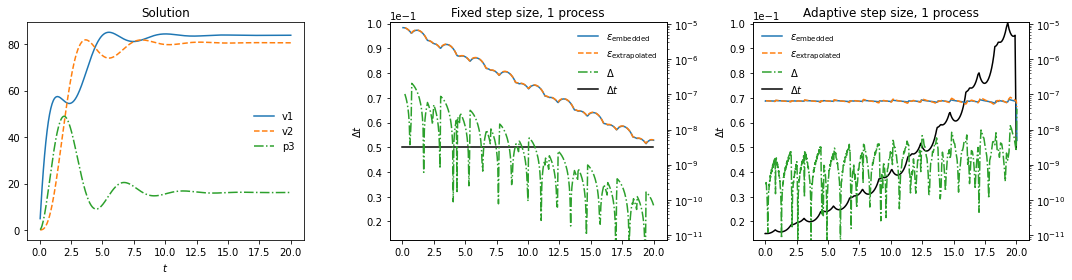

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
stats = run_piline(False, 1)
plot_solution(stats, axs[0])
axs[0].set_title('Solution')
plot_and_test(stats, False, 1, ax=axs[1])
axs[1].set_title('Fixed step size, 1 process')
plot_and_test(run_piline(True, 1), True, 1, ax=axs[2])
axs[2].set_title('Adaptive step size, 1 process')
fig.tight_layout()
plt.show()

The Pi-line equation is a linear ordinary differential equation with three components, that are approaching a fixed state over time, which you can see in the left panel.
The other panels show the error and the difference, which is used for detecting soft faults, as well as the time step size in black.

As the solution approaches the fixed state, the time scale of the problem gets longer, which means when we keep the step size fixed, the error goes down, like in the middle plot.
Since this means we cannot chose a sensible detection threshold as you either restart unaffected steps in the beginning or don't catch faults later on, we would prefer to combine Hot Rod with adaptivity, which you can see in the right panel.

### Parallel-in-time Hot Rod
With block Gauss-Seidel SDC, we can extend Hot Rod to PinT rather easily.
It is important to know the order of the scheme, which is why we only have an implementation for block Gauss-Seidel and not for other flavors of PinT SDC so far and only for fixed numbers of iterations.

The simplest extension is to use steps that are computed on different processes for the extrapolation instead of keeping them in memory and to do nothing else.
Meaning not changing the prefactor or anything like that.
This has the major advantage of eliminating the memory overhead, since we have the solutions in memory anyways.
The disadvantage is that we get a start-up phase in every block.
We can only extrapolate when we have sufficiently many solutions available after all, which is in fact also why we use the right hand side evaluations, to cut this is in half.
For a scheme with $k$ iterations, we do a Taylor expansion up to order $k+2$, which means we need $k/2+1$ solutions to steps in memory, but after that, we can extrapolate every step in the block.

Let's see how this looks in practice:

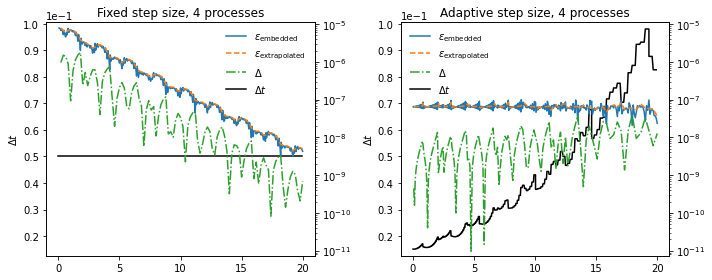

AssertionError: 

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
plot_and_test(run_piline(False, 4), False, 4, ax=axs[0])
axs[0].set_title('Fixed step size, 4 processes')
plot_and_test(run_piline(True, 4), True, 4, ax=axs[1])
axs[1].set_title('Adaptive step size, 4 processes')
fig.tight_layout()
plt.show()

As you can see, Hot Rod still works with this minimal effort PinT extension, but the difference between the error estimates and $\Delta$ is significantly smaller.
Maybe, the prefactor can be refined to make Hot Rod more efficient again.

### How can you use Hot Rod with pySDC?
You essentially need to set two variables in the `controller_params`:
```
controller_params['use_HotRod'] = True
controller_params['HotRod_tol'] = <your tolerance>
```
Also you need to satisfy the same requirements for a fixed and known order as in adaptivity, so refer to that notebook for how to do that.
It is also recommended to use adaptivity in conjunction with Hot Rod anyways.

To record the error estimates, simply put the following in the `post_step` hook:
```
self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                  sweep=L.status.sweep, type='e_embedded', value=L.status.error_embedded_estimate)
self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                  sweep=L.status.sweep, type='e_extrapolated', value=L.status.error_extrapolation_estimate)
```